## - Import libaries

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, utils, models
from torch.utils.data import Dataset
from torchsummary import summary
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time
import copy



## - Set GPU Envrionment

In [7]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

## - Set Hyper-parameters
  

In [67]:
# For Training
EPOCHS     =10
BATCH_SIZE = 128

# For Optimizer
LR         = 0.001
MOMENTUM   = 0.9

## - Prepare the Dataset

In [46]:

transform = transforms.Compose([
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [43]:
img_train_data = []
for d, l in  trainset:
    if l == 1:
        img_train_data.append([d, 0 ])
    elif l == 9:
        img_train_data.append([d, 1 ])

In [47]:
img_train_data = np.array(img_train_data)
img_train_data.shape

<ipython-input-47-64322b7801eb>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  img_train_data = np.array(img_train_data)
<ipython-input-47-64322b7801eb>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  img_train_data = np.array(img_train_data)


(10000, 2)

In [48]:
img_train_data[0][0].shape, img_train_data[0][1]

(torch.Size([3, 32, 32]), 1)

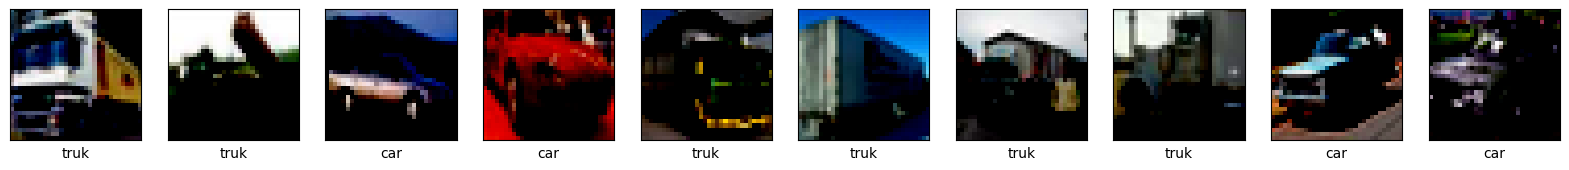

In [49]:
class_names = ['car', 'truk']

np.random.seed(15)
torch.manual_seed(0)

grid_size = 10

plt.figure(figsize=(20,200))
for i in range(grid_size):
    plt.subplot(1,grid_size,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.array(img_train_data[i][0]).transpose([1, 2, 0]))
    plt.xlabel(class_names[img_train_data[i][1]])
plt.show()


In [50]:
img_test_data = []
for d, l in  testset:
    if l == 1:
        img_test_data.append([d, 0 ])
    elif l == 9:
        img_test_data.append([d, 1 ])

## - Make CustomDataSet

In [51]:
class CustomDataset(Dataset):
  def __init__(self, new_dataset_raw, transform):
    self.data = new_dataset_raw
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    x = self.transform(self.data[idx][0])
    y = torch.tensor(self.data[idx][1])
    return x, y


In [68]:

transform_CARS = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

train_loader = torch.utils.data.DataLoader(
    CustomDataset(
        img_train_data,
        transform = transform_CARS),
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory = True
)


test_loader = torch.utils.data.DataLoader(
    CustomDataset(
        img_test_data,
        transform = transform_CARS),
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory = True
)

## - Prepare a Model for Whole training

https://pytorch.org/vision/stable/models.html

In [53]:
model_ft = models.resnet18(weights='ResNet18_Weights.DEFAULT')

print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [54]:
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=LR, momentum=MOMENTUM)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [55]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## - Training the Whole Model

In [56]:
def train(model, train_loader, optimizer, epoch, exp_lr_scheduler):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        exp_lr_scheduler.step()

        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [57]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [61]:
for epoch in range(1, EPOCHS + 1):
    train(model_ft, train_loader, optimizer_ft, epoch, exp_lr_scheduler)
    test_loss, test_accuracy = evaluate(model_ft, test_loader)

    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format( epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/10000 (0%)]	Loss: 0.766255
Train Epoch: 1 [1600/10000 (16%)]	Loss: 0.911101


KeyboardInterrupt: ignored

## - Predict and Visualize

In [62]:
def visualize(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(20,200))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(1, num_images, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))

                plt.imshow(inputs[j].numpy().transpose([1,2,0]))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

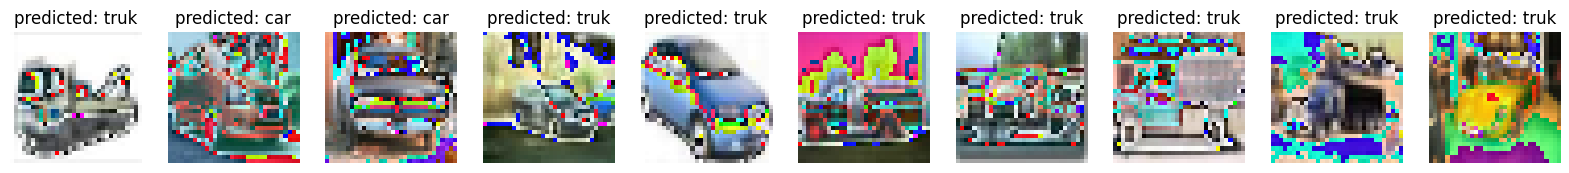

In [63]:
visualize(model_ft)

## - Prepare a Model for only Classifier Training (ConvNet as Fixed Feature Extractor)

https://pytorch.org/vision/stable/models.html

In [64]:
model_conv = models.resnet18(weights='ResNet18_Weights.DEFAULT')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=LR, momentum=MOMENTUM)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## - Training only the Classifier

In [69]:

for epoch in range(1,2):
    train(model_ft, train_loader, optimizer_ft, epoch, exp_lr_scheduler)
    test_loss, test_accuracy = evaluate(model_ft, test_loader)

    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format( epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/10000 (0%)]	Loss: 0.839926


KeyboardInterrupt: ignored

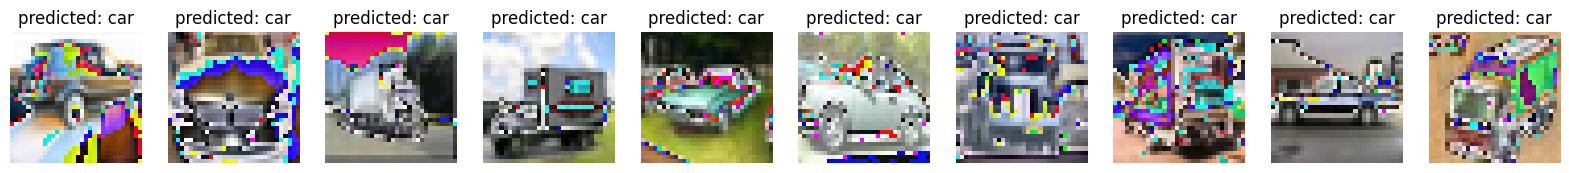

In [70]:
visualize(model_conv)

## - Save & Load

In [ ]:
# Save model
torch.save(model_ft, 'transferresnet.pt')

In [ ]:
# Load model
model = torch.load('transferresnet.pt')

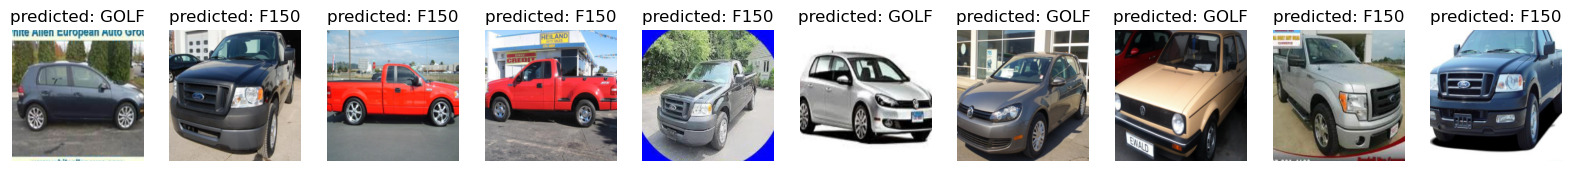

In [ ]:
visualize(model)